In [2]:
# Import packages.
import cvxpy as cp
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [3]:
'''
Experiment 1:
in-sample vs out-of-sample
LSMT -> beta vs Transformer -> beta, box, elliposoid -> return
'''

'\nExperiment 1:\nin-sample vs out-of-sample\nLSMT -> beta vs Transformer -> beta, box, elliposoid -> return\n'

In [4]:
import pickle
import os

with open(os.path.dirname(os.path.dirname(os.getcwd()))+"/Prepare_Datasets/out_of_sample_indicators.pkl", "rb") as f:
    out_of_sample_indicators = pickle.load(f)
    # for i in out_of_sample_indicators:
    #   print(out_of_sample_indicators[i]['train'])
    #   print(out_of_sample_indicators[i]['test'])


In [5]:
# LSTM 
beta0 = 0.33297149767585127
# Transformer
beta1 = 0.33125230431414276

In [6]:
# Box uncertainty set
# LSTM
resultsw = np.zeros((6, 12))

for i in range(6):
    samples_dic = out_of_sample_indicators[i]['train']
    samples = np.array(list(samples_dic.values()))
    sample_size = samples.shape
    # stock sample mean
    sample_mean = np.mean(samples, axis=0)
    # stock sample variance
    sample_variance = np.cov(samples, rowvar=False)
    # N assets
    N = samples.shape[1]
    # S sample
    S = samples.shape[0]
    # Sigma
    Sig = sample_variance
    # Sigma^{1/2}
    Sig2 = np.linalg.cholesky(Sig)
    #print(np.allclose(Sig, Sig2 @ Sig2.T)) 
    # muhat
    mu = sample_mean
    #confidence level alpha
    alpha = 0.05
    # standard norm quantile
    z_95 = stats.norm.ppf(1-alpha)
    z_975 = stats.norm.ppf(1-alpha/2)
    # delta^2 = chi^2 quantile
    delta2 = stats.chi2.ppf(1-alpha, df=N)
    # lambda0
    lambda0 = 0.5
    # Box uncertainty set
    A = np.hstack((Sig2, np.zeros((N,1))))
    e = np.ones(N+1)
    e[-1] = 0
    # LSTM
    c = mu - (1 - 2 * beta0) * (z_975 / np.sqrt(S)) * Sig2 @ np.ones((N))
    c = np.append(c, 1)
    c = c / ((1 - lambda0) * z_95)
    e = np.ones(N + 1)
    e[-1] = 0
    # Set random seed
    np.random.seed(0)
    # SOCP
    # min  f^T x
    # s.t. |||Ax +b|| <=c^T x + d
    #      e^T x = 1
    # Objective function coefficient
    f = np.zeros(N + 1)
    f[-1] = 1
    # Define variables x = [w, t]^T
    x = cp.Variable(N + 1)
    # SOC constraints
    soc_constraints = [cp.SOC(c.T @ x, A @ x)]
    # Define and solve the CVXPY problem
    prob = cp.Problem(cp.Minimize(f.T @ x), soc_constraints + [e.T @ x == 1] + [x[:-1] >= 0])
    prob.solve() 
    w0 = x.value[:-1]
    resultsw[i] = w0

print(resultsw)

[[-8.49209370e-10 -4.09624045e-10  2.55772835e-10  9.86155652e-03
   1.24591011e-01  4.69135119e-09  8.49850226e-02  7.03508002e-02
   1.21185702e-01  6.13725954e-02  1.22855969e-01  4.04797339e-01]
 [-1.93927827e-09 -9.52404841e-10  7.44636210e-10  1.54143693e-08
   1.82085304e-01  7.54420421e-03  7.46053318e-02  1.00141851e-01
   1.02652144e-01  5.74397787e-09  3.73811711e-02  4.95589975e-01]
 [-4.91794332e-10 -3.17313240e-10 -6.83999893e-11  6.10910300e-03
   1.89523379e-01  5.04667888e-09  6.51600708e-09  9.86243911e-02
   1.37147373e-01  1.01737902e-01  5.82116638e-02  4.08646177e-01]
 [-3.19213494e-10  9.73125589e-11  5.21133733e-11  1.67360929e-09
   3.11147815e-09  5.11533938e-10  8.08461394e-02  6.92427668e-02
   2.26952593e-01  1.39792926e-01  5.79040057e-02  4.25261564e-01]
 [-2.21312687e-09  1.60116825e-03 -5.74603064e-10  1.99194735e-02
   1.84016462e-01  2.19984831e-09  3.06815872e-08  4.76829871e-02
   1.78243970e-01  1.07178624e-01  6.97873815e-02  3.91569904e-01]
 [-1.

In [7]:
# Box uncertainty set
# LSTM
results = []
for i in range(6):
    samples_dic = out_of_sample_indicators[i]['test']
    samples = np.array(list(samples_dic.values()))
    # S sample
    S = samples.shape[0]
    value = np.cumsum(samples @ resultsw[i])
    results.append(value)
print(results)

[array([ 0.03343418, -0.72224225, -1.12836696,  0.01143357, -0.80352072]), array([ 0.9822312 ,  0.78358195,  0.87798559,  0.54632545, -0.62471272]), array([-0.61429628, -1.3479705 , -3.86452364, -2.61489919, -4.31562256]), array([1.66159007, 1.49718496, 3.69424136, 5.03063154, 3.7073069 ]), array([-0.84808427,  0.0255159 , -0.05522601, -0.81896112, -1.22428362]), array([-0.18793583,  0.61155549, -0.4043403 ,  0.09491915,  0.53487307])]


In [ ]:
# Ellipsoidal uncertainty set
# TLSTM
resultsw1 = np.zeros((6, 12))

for i in range(6):
    samples_dic = out_of_sample_indicators[i]['train']
    samples = np.array(list(samples_dic.values()))
    sample_size = samples.shape
    # stock sample mean
    sample_mean = np.mean(samples, axis=0)
    # stock sample variance
    sample_variance = np.cov(samples, rowvar=False)
    # N assets
    N = samples.shape[1]
    # S sample
    S = samples.shape[0]
    # Sigma
    Sig = sample_variance
    # Sigma^{1/2}
    Sig2 = np.linalg.cholesky(Sig)
    #print(np.allclose(Sig, Sig2 @ Sig2.T)) 
    # muhat
    mu = sample_mean
    #confidence level alpha
    alpha = 0.05
    # standard norm quantile
    z_95 = stats.norm.ppf(1-alpha)
    z_975 = stats.norm.ppf(1-alpha/2)
    # delta^2 = chi^2 quantile
    delta2 = stats.chi2.ppf(1-alpha, df=N)
    # lambda0
    lambda0 = 0.5
    # Box uncertainty set
    A = np.hstack((Sig2, np.zeros((N,1))))
    e = np.ones(N+1)
    e[-1] = 0
    # Transformer
    c = mu - (1 - 2 * beta1) * (z_975 / np.sqrt(S)) * Sig2 @ np.ones((N))
    c = np.append(c, 1)
    c = c / ((1 - lambda0) * z_95)
    e = np.ones(N + 1)
    e[-1] = 0
    # Set random seed
    np.random.seed(0)
    # SOCP
    # min  f^T x
    # s.t. |||Ax +b|| <=c^T x + d
    #      e^T x = 1
    # Objective function coefficient
    f = np.zeros(N + 1)
    f[-1] = 1
    # Define variables x = [w, t]^T
    x = cp.Variable(N + 1)
    # SOC constraints
    soc_constraints = [cp.SOC(c.T @ x, A @ x)]
    # Define and solve the CVXPY problem
    prob = cp.Problem(cp.Minimize(f.T @ x), soc_constraints + [e.T @ x == 1] + [x[:-1] >= 0])
    prob.solve() 
    w0 = x.value[:-1]
    resultsw1[i] = w0

print(resultsw1)
   

[[-8.78916129e-10 -4.23743911e-10  2.65435179e-10  9.79487670e-03
   1.24868883e-01  4.66010072e-09  8.50456264e-02  7.03818169e-02
   1.21363425e-01  6.12521256e-02  1.22706391e-01  4.04586851e-01]
 [-1.81965764e-09 -9.01389322e-10  7.02359672e-10  1.44234208e-08
   1.82264002e-01  7.48550404e-03  7.46803589e-02  1.00151719e-01
   1.02864144e-01  5.56502826e-09  3.71761467e-02  4.95378108e-01]
 [-5.10098426e-10 -3.29096478e-10 -7.06657588e-11  6.08187164e-03
   1.89683362e-01  5.24251906e-09  6.70864897e-09  9.87550042e-02
   1.37211623e-01  1.01663241e-01  5.81917043e-02  4.08413183e-01]
 [-2.82356033e-10  8.45386876e-11  4.54494911e-11  1.31043342e-09
   2.53339207e-09  4.47574618e-10  8.10450255e-02  6.93600745e-02
   2.27023893e-01  1.39827498e-01  5.76139209e-02  4.25129585e-01]
 [-2.04982940e-09  1.58164213e-03 -5.57329241e-10  1.98767118e-02
   1.84352733e-01  2.08633167e-09  3.24617663e-08  4.77308273e-02
   1.78297868e-01  1.07228739e-01  6.96311742e-02  3.91300273e-01]
 [-1.

In [ ]:
# Ellipsoidal uncertainty set
# LSTM
results1 = []
for i in range(6):
    samples_dic = out_of_sample_indicators[i]['test']
    samples = np.array(list(samples_dic.values()))
    # S sample
    S = samples.shape[0]
    value = np.cumsum(samples @ resultsw1[i])
    results1.append(value)
print(results1)

[array([ 0.03328282, -0.72244605, -1.12858708,  0.01109178, -0.80383083]), array([ 0.98233186,  0.78354985,  0.87824414,  0.54677182, -0.62373842]), array([-0.61422201, -1.34778574, -3.86324864, -2.61404172, -4.31494622]), array([1.66092655, 1.49596234, 3.69213925, 5.0287214 , 3.70543108]), array([-0.8482959 ,  0.02481319, -0.05593508, -0.81962179, -1.2249507 ]), array([-0.18785344,  0.61129732, -0.4042504 ,  0.09506955,  0.53494382])]


In [ ]:
# Box uncertainty set
# Transformer
resultsw10 = np.zeros((6, 12))

for i in range(6):
    samples_dic = out_of_sample_indicators[i]['train']
    samples = np.array(list(samples_dic.values()))
    sample_size = samples.shape
    # stock sample mean
    sample_mean = np.mean(samples, axis=0)
    # stock sample variance
    sample_variance = np.cov(samples, rowvar=False)
    # N assets
    N = samples.shape[1]
    # S sample
    S = samples.shape[0]
    # Sigma
    Sig = sample_variance
    # Sigma^{1/2}
    Sig2 = np.linalg.cholesky(Sig)
    #print(np.allclose(Sig, Sig2 @ Sig2.T)) 
    # muhat
    mu = sample_mean
    #confidence level alpha
    alpha = 0.05
    # standard norm quantile
    z_95 = stats.norm.ppf(1-alpha)
    z_975 = stats.norm.ppf(1-alpha/2)
    # delta^2 = chi^2 quantile
    delta2 = stats.chi2.ppf(1-alpha, df=N)
    # lambda0
    lambda0 = 0.5
    # Elliptical set
    A1 = np.hstack((Sig2, np.zeros((N,1))))
    e1 = np.ones(N+1)
    e1[-1] = 0
    # LSTM
    c1 = np.append(mu, 1)
    a = (1-lambda0)*z_95 + (1-2*beta0)*np.sqrt(delta2/S)
    c1 = c1/a
    # Set random seed
    np.random.seed(0)
    # SOCP
    # min  f^T x
    # s.t. |||Ax +b|| <=c^T x + d
    #      e^T x = 1
    # objective function coeficient
    f1 = np.zeros(N + 1)
    f1[-1] = 1      
    # define variables x=[w,t]^T
    x1 = cp.Variable(N+1)
    # SOC constraints
    soc_constraints1 = [cp.SOC(c1.T @ x1 , A1 @ x1 )]
    # Define and solve the CVXPY problem.
    prob1 = cp.Problem(cp.Minimize(f1.T@x1),
                    soc_constraints1 + [e1.T @ x1 == 1]+ [x1[:-1] >= 0])
    prob1.solve()
    w10 = x1.value[:-1]
    resultsw10[i] = w10

print(resultsw10)

[[-8.21528623e-10 -3.61860170e-10  1.54785259e-10  1.80429243e-02
   1.02568714e-01  1.08833595e-07  7.90355547e-02  6.65666395e-02
   1.01737127e-01  6.94176745e-02  1.35279699e-01  4.27351560e-01]
 [-1.41387682e-09 -7.40916374e-10  4.37089102e-10  2.90829622e-03
   1.64050267e-01  1.11630281e-02  6.64734384e-02  9.79822647e-02
   8.62347738e-02  5.57576665e-09  5.59467430e-02  5.15241185e-01]
 [-9.80927201e-10 -6.45900720e-10 -2.26111806e-10  8.87389648e-03
   1.76759538e-01  8.18909236e-09  2.29823947e-08  8.62660320e-02
   1.27478043e-01  1.08232639e-01  6.01170317e-02  4.32272791e-01]
 [-2.55731843e-09  3.41122503e-10  2.89247740e-10  2.74526629e-08
   2.09273962e-08  4.27350214e-09  6.16960019e-02  5.80139081e-02
   2.17712215e-01  1.35859324e-01  8.63514848e-02  4.40367015e-01]
 [-1.73794116e-09  2.72755281e-03 -7.44243094e-10  2.38110540e-02
   1.50514884e-01  2.10830079e-09  1.39661514e-08  4.47221441e-02
   1.74496360e-01  1.04646626e-01  8.35600721e-02  4.15521294e-01]
 [-1.

In [ ]:
# Box uncertainty set
# Transformer
results10 = []
for i in range(6):
    samples_dic = out_of_sample_indicators[i]['test']
    samples = np.array(list(samples_dic.values()))
    # S sample
    S = samples.shape[0]
    value = np.cumsum(samples @ resultsw10[i])
    results10.append(value)
print(results10)

[array([ 0.04464118, -0.69171546, -1.10353252,  0.0571372 , -0.76284668]), array([ 0.97434063,  0.78803101,  0.85488259,  0.50502771, -0.71548667]), array([-0.62522157, -1.37248359, -3.98847675, -2.70631074, -4.3838192 ]), array([1.73166792, 1.62417278, 3.91075742, 5.22924093, 3.89669494]), array([-0.82560542,  0.0912714 ,  0.00682121, -0.76009613, -1.16644516]), array([-0.19658523,  0.63689394, -0.41006456,  0.08153402,  0.53006357])]


In [12]:
# Ellipical uncertainty set
# Transformer
resultsw11 = np.zeros((6, 12))

for i in range(6):
    samples_dic = out_of_sample_indicators[i]['train']
    samples = np.array(list(samples_dic.values()))
    sample_size = samples.shape
    # stock sample mean
    sample_mean = np.mean(samples, axis=0)
    # stock sample variance
    sample_variance = np.cov(samples, rowvar=False)
    # N assets
    N = samples.shape[1]
    # S sample
    S = samples.shape[0]
    # Sigma
    Sig = sample_variance
    # Sigma^{1/2}
    Sig2 = np.linalg.cholesky(Sig)
    #print(np.allclose(Sig, Sig2 @ Sig2.T)) 
    # muhat
    mu = sample_mean
    #confidence level alpha
    alpha = 0.05
    # standard norm quantile
    z_95 = stats.norm.ppf(1-alpha)
    z_975 = stats.norm.ppf(1-alpha/2)
    # delta^2 = chi^2 quantile
    delta2 = stats.chi2.ppf(1-alpha, df=N)
    # lambda0
    lambda0 = 0.5
    # Elliptical set
    A1 = np.hstack((Sig2, np.zeros((N,1))))
    e1 = np.ones(N+1)
    e1[-1] = 0
    # Transformer
    c1 = np.append(mu, 1)
    a = (1-lambda0)*z_95 + (1-2*beta1)*np.sqrt(delta2/S)
    c1 = c1/a
    # Set random seed
    np.random.seed(0)
    # SOCP
    # min  f^T x
    # s.t. |||Ax +b|| <=c^T x + d
    #      e^T x = 1
    # objective function coeficient
    f1 = np.zeros(N + 1)
    f1[-1] = 1      
    # define variables x=[w,t]^T
    x1 = cp.Variable(N+1)
    # SOC constraints
    soc_constraints1 = [cp.SOC(c1.T @ x1 , A1 @ x1 )]
    # Define and solve the CVXPY problem.
    prob1 = cp.Problem(cp.Minimize(f1.T@x1),
                    soc_constraints1 + [e1.T @ x1 == 1]+ [x1[:-1] >= 0])
    prob1.solve()
    w11 = x1.value[:-1]
    resultsw11[i] = w11

print(resultsw11)


[[-8.62503125e-10 -3.82901941e-10  1.61880530e-10  1.80598834e-02
   1.02615899e-01  1.20441387e-07  7.90345683e-02  6.65589571e-02
   1.01715355e-01  6.93824780e-02  1.35260027e-01  4.27372712e-01]
 [-1.47793883e-09 -7.73782761e-10  4.57105948e-10  2.91175033e-03
   1.64052203e-01  1.11423306e-02  6.64677292e-02  9.79788330e-02
   8.62755521e-02  5.64774224e-09  5.59361028e-02  5.15235495e-01]
 [-9.67980531e-10 -6.37081954e-10 -2.23601411e-10  8.87501942e-03
   1.76786133e-01  8.05299054e-09  2.25204300e-08  8.62690140e-02
   1.27444929e-01  1.08225427e-01  6.01166896e-02  4.32282759e-01]
 [-2.61043179e-09  3.43295433e-10  2.88740109e-10  2.79243707e-08
   2.13623886e-08  4.36016249e-09  6.16955431e-02  5.80139876e-02
   2.17689001e-01  1.35853700e-01  8.63590011e-02  4.40388715e-01]
 [-1.71951984e-09  2.71965731e-03 -7.37320937e-10  2.38084886e-02
   1.50504388e-01  2.08316677e-09  1.38304311e-08  4.47395124e-02
   1.74510623e-01  1.04670500e-01  8.35474595e-02  4.15499357e-01]
 [-1.

In [13]:
# Ellipical uncertainty set
# Transformer
results11 = []
for i in range(6):
    samples_dic = out_of_sample_indicators[i]['test']
    samples = np.array(list(samples_dic.values()))
    # S sample
    S = samples.shape[0]
    value = np.cumsum(samples @ resultsw11[i])
    results11.append(value)
print(results11)

[array([ 0.0446084 , -0.69160936, -1.10349734,  0.0572611 , -0.76274177]), array([ 0.97433625,  0.7880247 ,  0.85488911,  0.50502792, -0.71546242]), array([-0.62525735, -1.3725469 , -3.98847915, -2.70638987, -4.38384401]), array([1.73172952, 1.62426741, 3.91090263, 5.22939169, 3.89678941]), array([-0.82558367,  0.09124962,  0.00675496, -0.76014606, -1.16651222]), array([-0.19659208,  0.63689734, -0.41003491,  0.0815455 ,  0.53008397])]


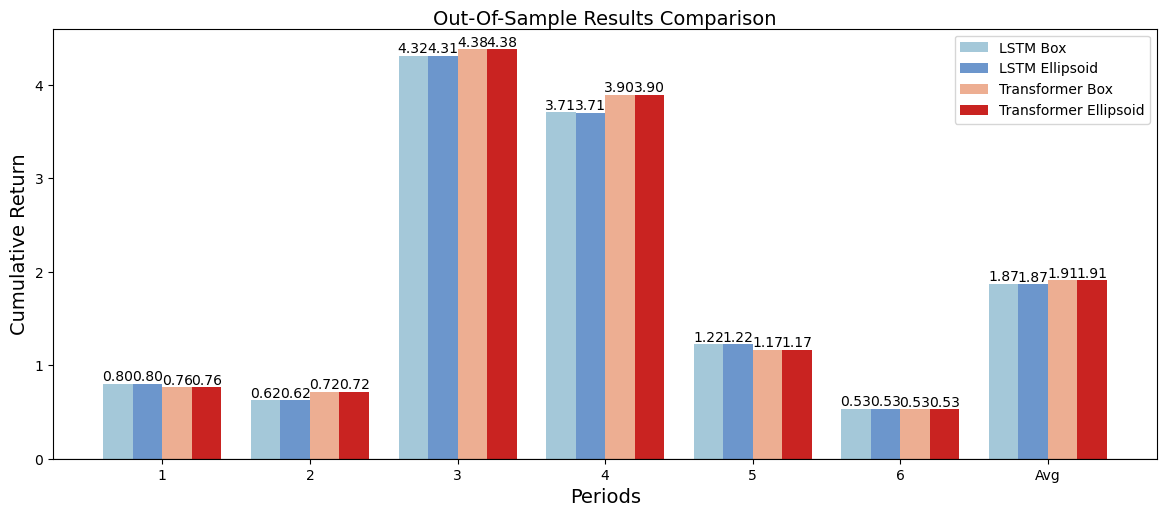

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Draw the results

# Extract the last element from each array in the results
last_elements = [result[-1] for result in results]
last_elements1 = [result[-1] for result in results1]
last_elements10 = [result[-1] for result in results10]
last_elements11 = [result[-1] for result in results11]

# Calculate the average values
avg_last_elements = np.mean(np.abs(last_elements))
avg_last_elements1 = np.mean(np.abs(last_elements1))
avg_last_elements10 = np.mean(np.abs(last_elements10))
avg_last_elements11 = np.mean(np.abs(last_elements11))

# Define the periods, adding an extra period for the average values
periods = np.arange(len(last_elements) + 1)

# Adjust the x-ticks to be at the center of each group of bars
xticks = periods[:-1] + 1.5 * bar_width
xticks = np.append(xticks, periods[-1] + 1.5 * bar_width)

# Plot the bar plot with specific colors
bar_width = 0.2
plt.figure(figsize=(12, 5))

bars1 = plt.bar(periods[:-1], np.abs(last_elements), bar_width, label='LSTM Box', color='#a4c8d9')
bars2 = plt.bar(periods[:-1] + bar_width, np.abs(last_elements1), bar_width, label='LSTM Ellipsoid', color='#6c96cc')
bars3 = plt.bar(periods[:-1] + 2 * bar_width, np.abs(last_elements10), bar_width, label='Transformer Box', color='#edae92')
bars4 = plt.bar(periods[:-1] + 3 * bar_width, np.abs(last_elements11), bar_width, label='Transformer Ellipsoid', color='#c92321')

# Plot the average values as the last period
avg_bars1 = plt.bar(periods[-1], avg_last_elements, bar_width, color='#a4c8d9')
avg_bars2 = plt.bar(periods[-1] + bar_width, avg_last_elements1, bar_width, color='#6c96cc')
avg_bars3 = plt.bar(periods[-1] + 2 * bar_width, avg_last_elements10, bar_width, color='#edae92')
avg_bars4 = plt.bar(periods[-1] + 3 * bar_width, avg_last_elements11, bar_width, color='#c92321')

# Add a horizontal line at y-axis 0
plt.axhline(0, color='black', linewidth=0.8)

# Label each bar with its corresponding value
for bars in [bars1, bars2, bars3, bars4, avg_bars1, avg_bars2, avg_bars3, avg_bars4]:
    for bar in bars:
        height = bar.get_height() 
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')
        
plt.xlabel('Periods', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)
plt.title('Out-Of-Sample Results Comparison', fontsize=14, y=0.99)
plt.xticks(xticks, labels=list(range(1, len(last_elements) + 1)) + ['Avg'])
plt.legend()
plt.subplots_adjust(left=0.05, right=0.97, top=0.95, bottom=0.09, hspace=0.4)
plt.savefig('bar_plot_results.pdf', dpi=800)
